In [4]:
import radd
from radd import build, vis
from radd.tools import analyze, utils

import numpy as np
import pandas as pd
import os

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [15]:
# define quantiles to use for summarizing RT dists
quantiles = np.arange(.1, 1., .1)

# define some colors for plotting
ec, uc, lc = "#3498db", '#6C7A89', "#9B59B6"
obsClrs = ['#3572C6', '#3f4850', "#663399"]
clrs = [ec, uc, lc] 

#define plotting labels
lbls = ['Early', 'Uniform', 'Late']

In [4]:
# Initial state of Stop process (red) depends on current strength of 
# Go activation (green) assumes Stop signal efficacy at later SSDs diminishes 
# as the state of the Go process approaches the execution threshold (upper bound). 
# (pink lines denote t=SSD, blue is trial deadline)
radd.load_dpm_animation()

## Static DPM Parameters 
$\,$

| $$\theta$$ | Description     | str id | Process |
|:----------:|:----------------|:------:|:-------:|
| $$a$$  | Threshold       |  'a'   | Execution      |
| $$tr$$ | Onset-Delay     |  'tr'  | Execution      |
| $$v_{E}$$  | Drift-Rate  |  'v'   | Execution      |  
| $$v_{B}$$  | Drift-Rate   |  'ssv' | Brake    |



## Adaptive Stop-Signal Task 

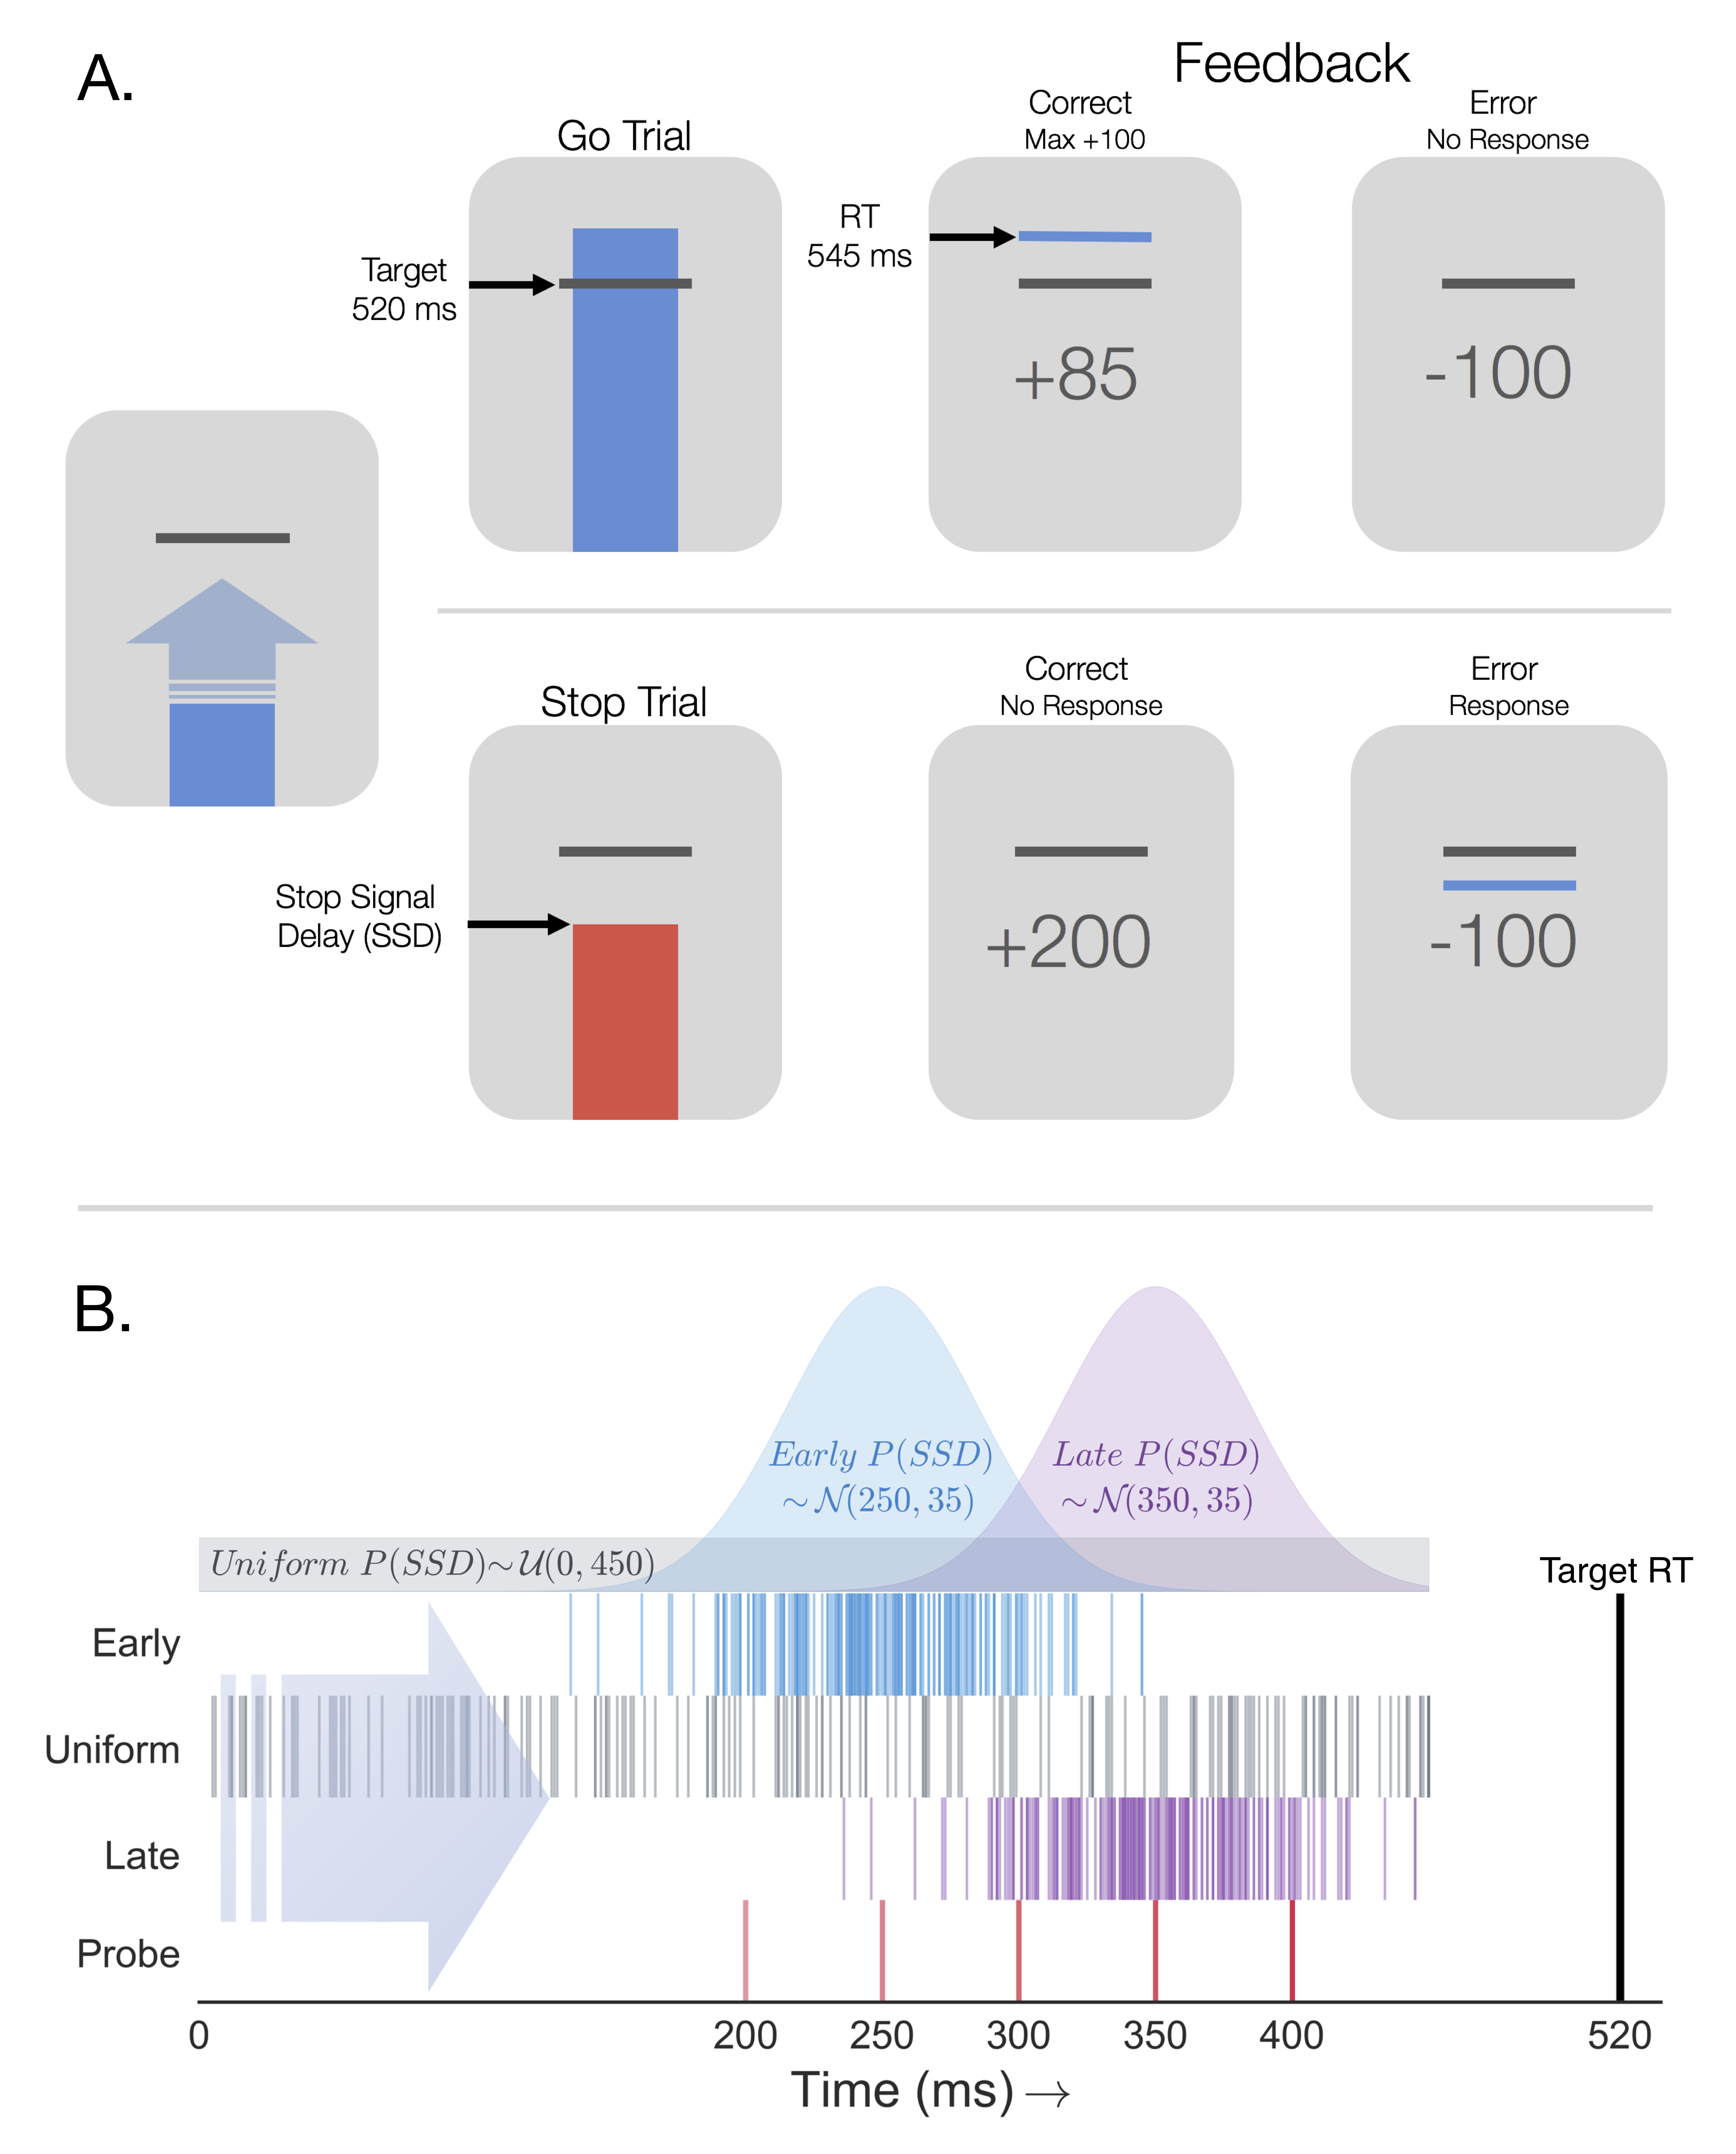

In [5]:
from IPython import display

# A. Example of Go and Stop trial feedack in moving bar task
# B. Stop-signal delay (SSD) distributions in Early, Uniform, & Late Contexts
task_fig = os.path.join(radd._package_dir, 'docs/examples/jneuro_task.png')
display.Image(task_fig, width='50%')

In [7]:
# read data Adaptive Stop-Signal data from Dunovan & Verstynen (2018)
data = radd.load_example_data(name='jneuro')
data.head()

,idx,cond,ttype,sstrial,ssd,ssdperc,probe,response,acc,rt,score,trial,block2,block4,block10,block15,block20,ssdvar,ssnoise
0,0,early,go,0,0,0.0,0,1,1,0.5720,0.6639,1,1,1,1,1,1,low,low
1,0,early,go,0,0,0.0,0,1,1,0.5151,1.0000,2,1,1,1,1,1,low,low
2,0,early,go,0,0,0.0,0,1,1,0.5155,1.0000,3,1,1,1,1,1,low,low
3,0,early,go,0,0,0.0,0,1,1,0.5326,0.8175,4,1,1,1,1,1,low,low
4,0,early,go,0,0,0.0,0,1,1,0.5489,0.7424,5,1,1,1,1,1,low,low


## Read in empirical behavioral data

In [8]:
# split up context data into separate DFs
udata = data[data.cond=='uniform'].reset_index(drop=True)
edata = data[data.cond=='early'].reset_index(drop=True)
ldata = data[data.cond=='late'].reset_index(drop=True)

# remove subjects with low trial-counts from late context group
lCounts = ldata.groupby('idx').count()
ldata = ldata[ldata.idx.isin(lCounts[lCounts.trial>200].index.values)]
eldata = pd.concat([edata, ldata]).reset_index()

## Fit static DPM to avg Uniform Context data

In [ ]:
# um = build.Model(data=udata, kind='dpm', quantiles=quantiles, ssd_method='all', fit_on='average')
# um.set_basinparams(method='basin', local_method='TNC', polish_tol=1e-25, T=.05, ninits=4, nsamples=4000)

# fit (Series): goodness-of-fit stats
# popt (dict): optimized parameters 
# yhat (array): model-predicted stop acc, cor RT quantiles, err RT quantiles
fit, popt, yhat = um.optimize_flat(get_results=True)

## Check optimized parameters (static DPM)

In [17]:
popt

{'a': 0.45507047906617348,
 'ssv': -0.71475380912676567,
 'tr': 0.12030275404600255,
 'v': 1.0790711368102408}

## Visualize Uniform fits

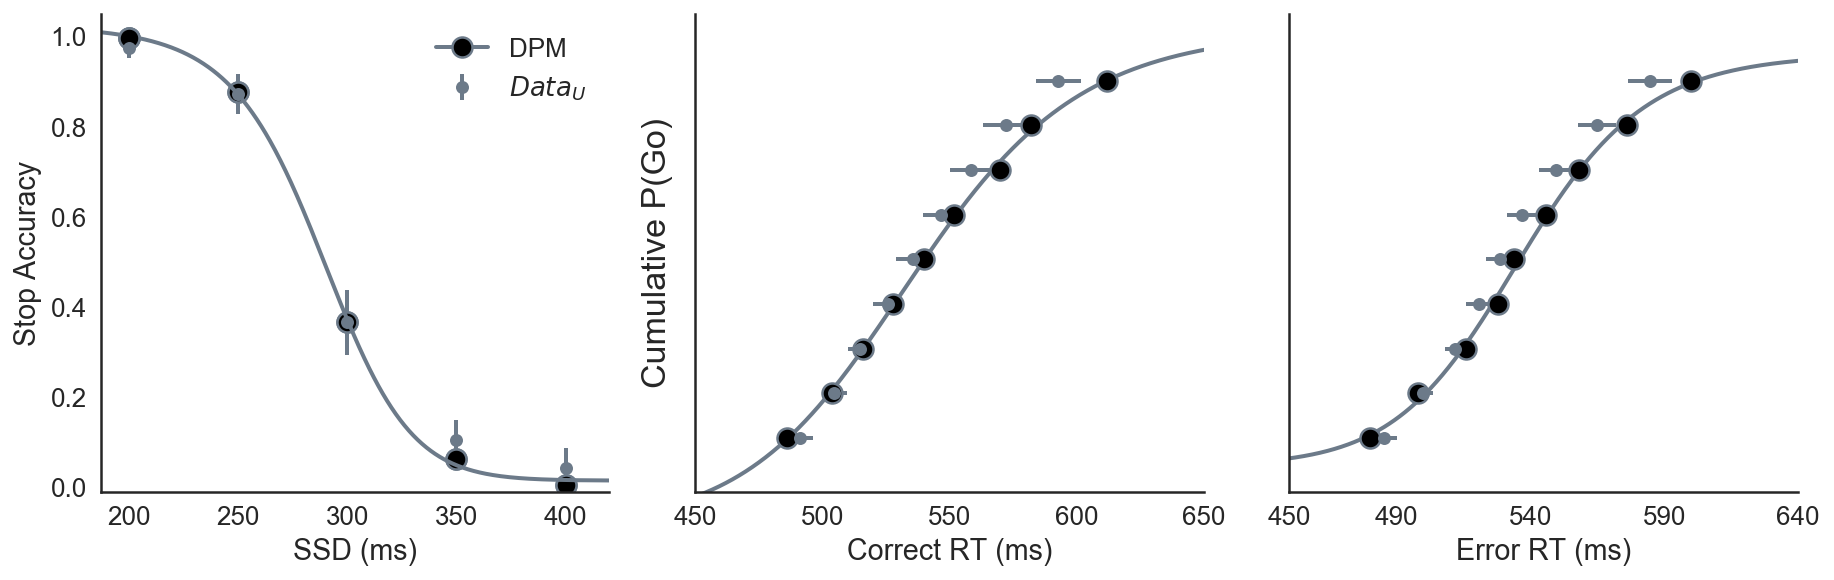

In [18]:
um.plot_model_fits(yhat=yhat, clrs=[uc], lbls=[['$Data_U$', 'DPM']])

## Nested DPM fits to Early/Late Contexts

In [ ]:
# define alternative models to compare 
# based on fits to Early & Late Contexts
nestedModels = [{'v': 'cond'}, # exec. drift free across Early/Late
                {'ssv': 'cond'}, # braking drift free
                {'v': 'cond', 'a': 'cond'}, # exec. drift & bound free
                {'v': 'cond', 'ssv': 'cond'}] # exec. & braking drift-rates free 

# build model object for fitting Early/Late data
model = build.Model(data=eldata, 
                    kind='dpm', 
                    depends_on=nestedModels[0], 
                    quantiles=quantiles, 
                    ssd_method='all', 
                    fit_on='average')

model.set_fitparams(dt=.004, ntrials=20000)
model.set_basinparams(method='basin', local_method='TNC', polish_tol=1e-25, T=.035)
# model.set_testing_params()


el_inits = None
if popt:
    # init all models with Uniform popt
    el_inits = deepcopy(popt)

# fitdf (DataFrame): GOF statistics for all nested models
# poptdf (DataFrame): optimized parameters for all models
# yhatdf (DataFrame): predicted data from all models
fitdf, poptdf, yhatdf = model.nested_optimize(depends=nestedModels, flatp=el_inits, progress=True)

## Compare nested model AIC/BIC's

AIC likes v_a model
BIC likes v_a model


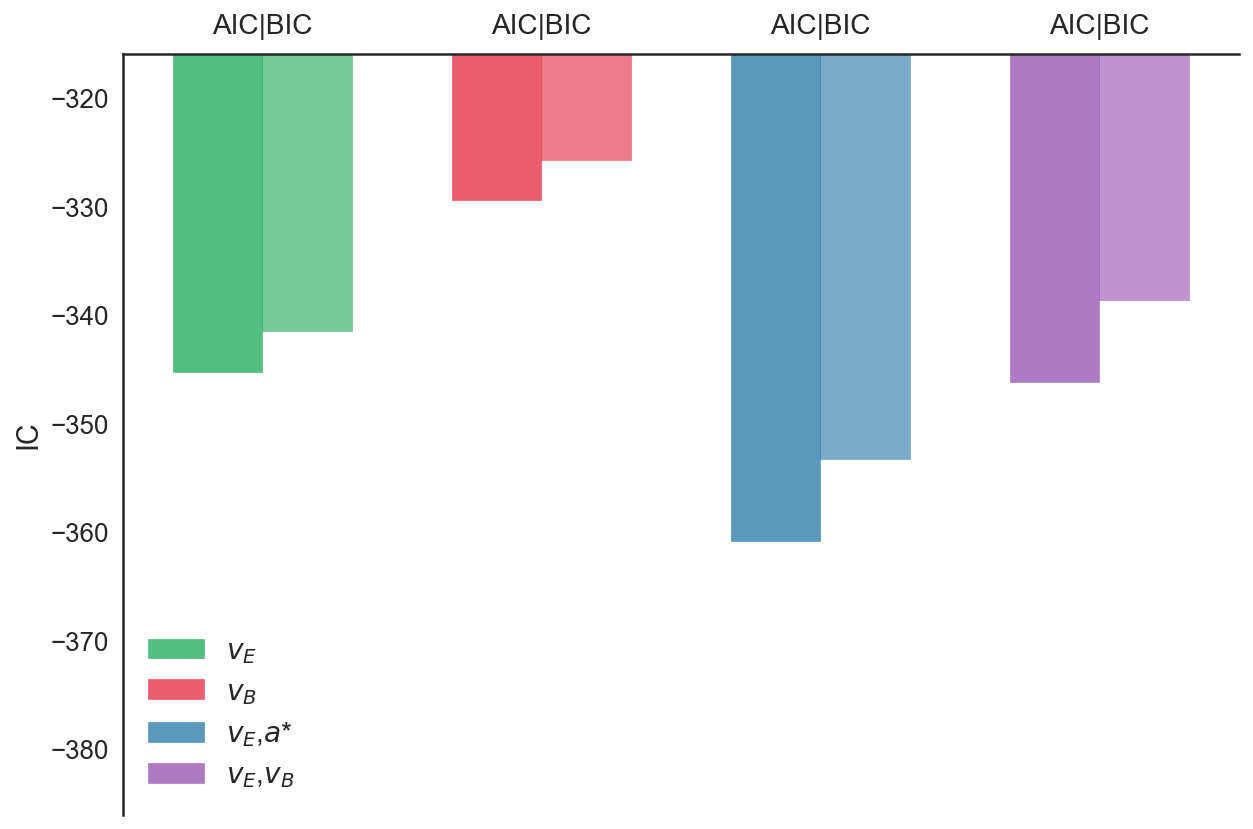

In [20]:
# Evaluate all nested fits and plot fit stats: 
# The model with the lowest AIC/BIC provides the best fit
model_ids=['_'.join(p) for p in [list(m) for m in nestedModels]]
gof = vis.compare_nested_models(fitdf, verbose=True, model_ids=model_ids)

## Visualize best-fitting model predictions

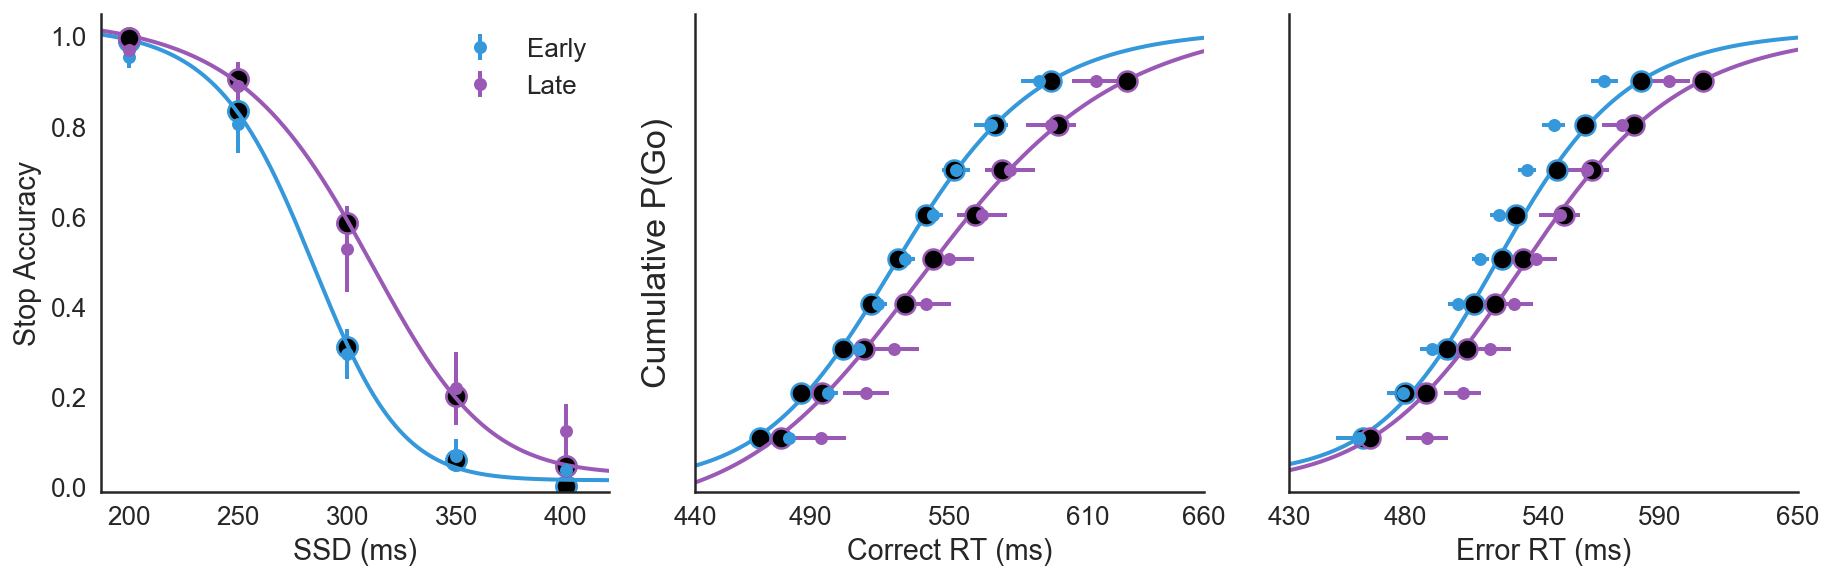

In [22]:
model.set_fitparams(force='cond')
yh = yhatdf[yhatdf.modelID=='v_a'].loc[:, 'acc':].values
lbls=[['Early', None], ['Late', None]]
model.plot_model_fits(yhat=yh, clrs=[ec, lc], lbls=lbls)

# Adaptive DPM
$\,$

| $$\theta$$ | Description     | str id | Error type |
|:----------:|:----------------|:------:|:-------:|
| $$\alpha$$  | Learning rate |  'AX'   |  RT  |
| $$\beta$$ | Learning rate  |  'BX'  |   Stop  |
| $$p$$  | Stop error sensitivity decay |  'PX'   | Stop  |  


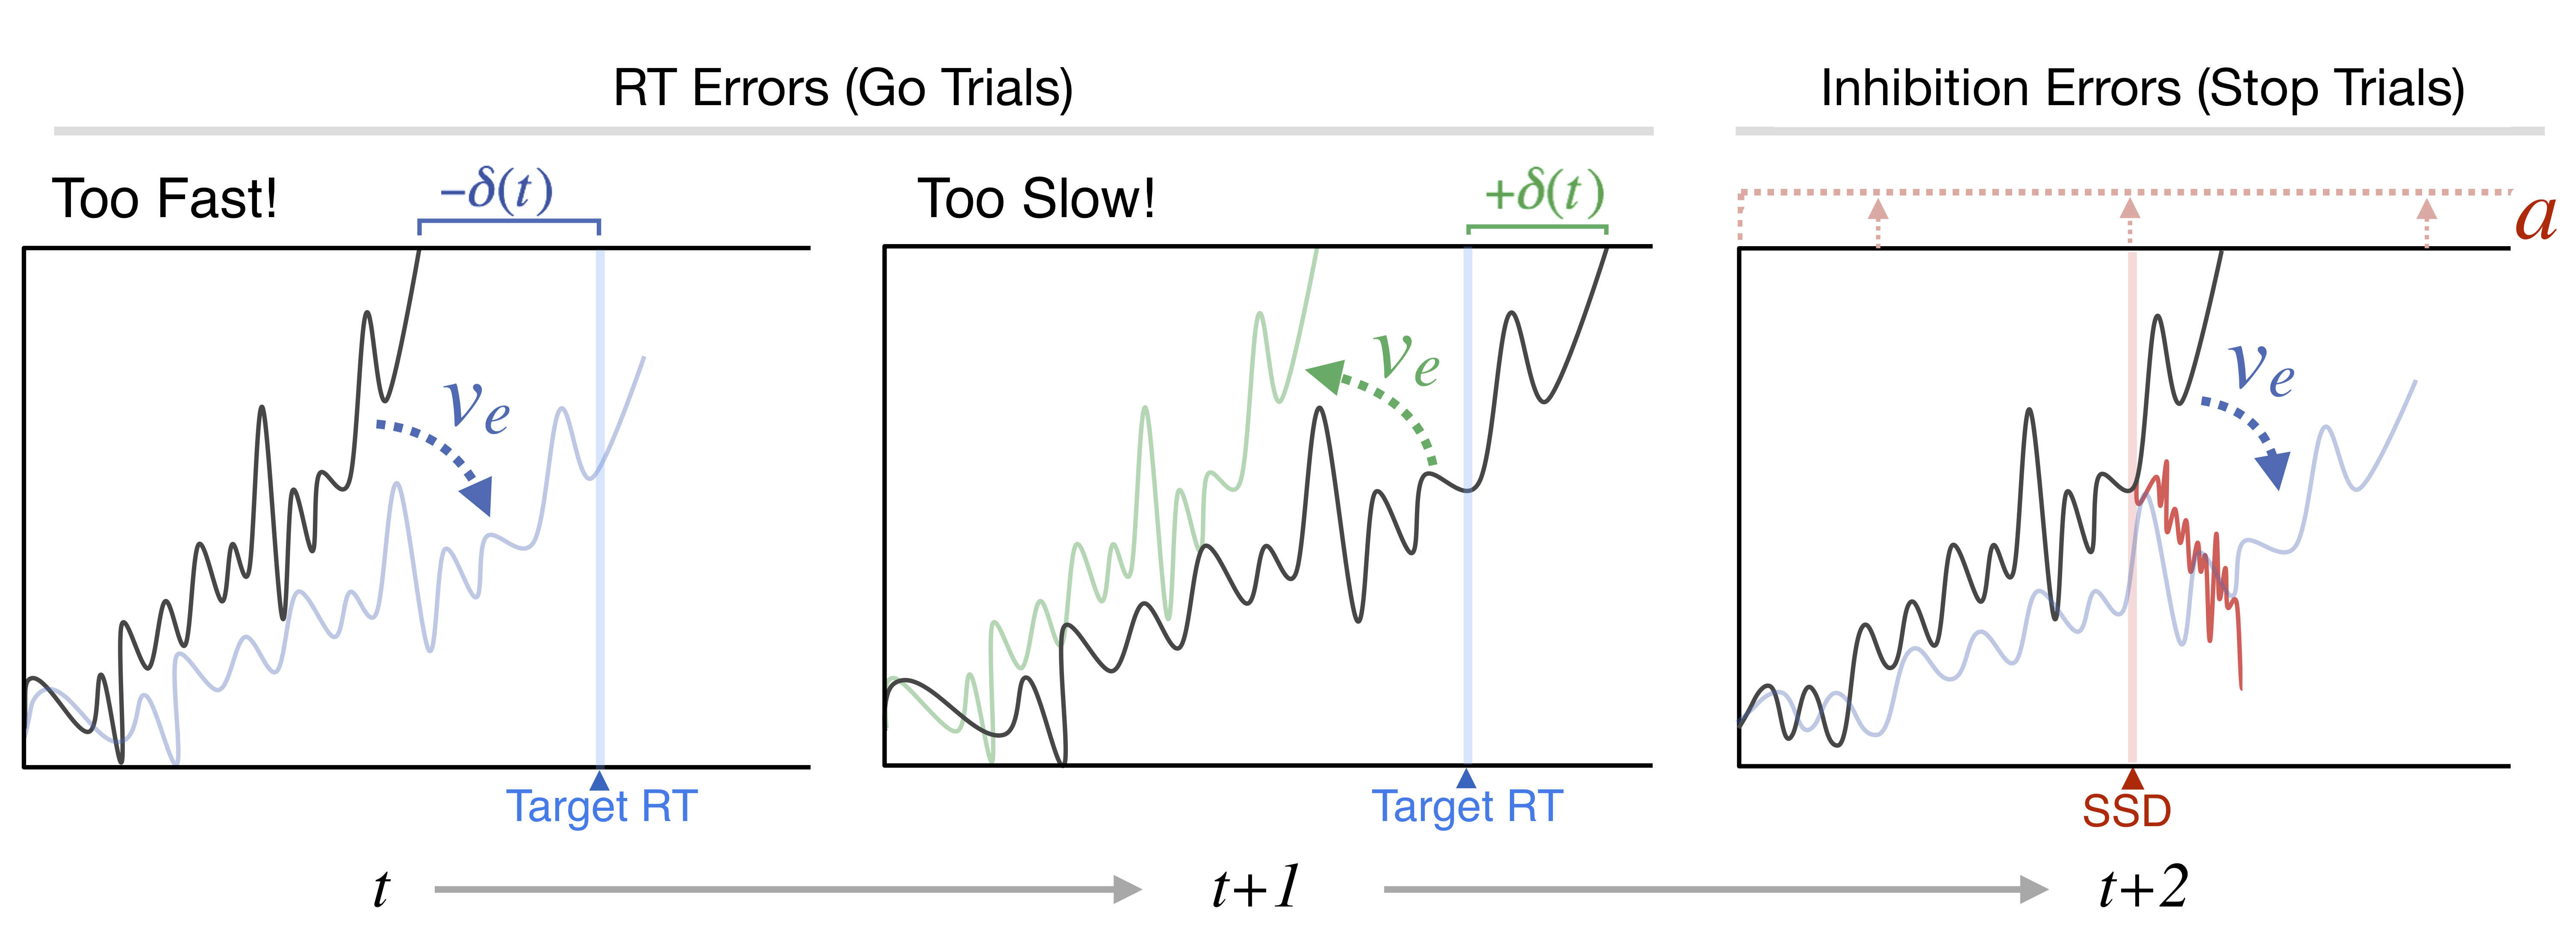

In [1]:
from IPython import display
# drift-rate adaptation following fast (left) and slow (middle) RT errors
# boundary and drift-rate adaptation on failed stop trials (right)
aDPM_fig = os.path.join(radd._package_dir, 'docs/examples/adaptiveDPM.png')
display.Image(aDPM_fig, width='90%')

## Build adaptive DPM 

In [10]:
# make a copy optimal Uniform params dict
adpm_inits = deepcopy(popt)

# instantiate model with learn = True for adaptive DPM
adpm = build.Model(data=udata, kind='dpm', learn=True)
# set some optimization parameters
adpm.set_fitparams(force='flat', inits=adpm_inits, maxfev=500, maxiter=500, dt=.005, ntrials=30000, tol=1e-15)

# pass init params to simulator (adds learning rate 
# & decay parameters for optimization)
adpm.simRL.update(inits=adpm_inits)

## Fit adaptive DPM to Uniform data

In [ ]:
apopt, fmin, out = adpm.opt.optimize_global(adpm_inits, learn=True, resetProgress=True, return_all=True)

## Check optimized Uniform parameters (adaptive)

In [21]:
apopt

{'AX': 0.13122133994550722,
 'BX': 0.042738281382948135,
 'PX': 0.0023599834268039355,
 'a': 0.4550704790661735,
 'ssv': -0.7147538091267657,
 'tr': 0.12030275404600255,
 'v': 1.0790711368102408}

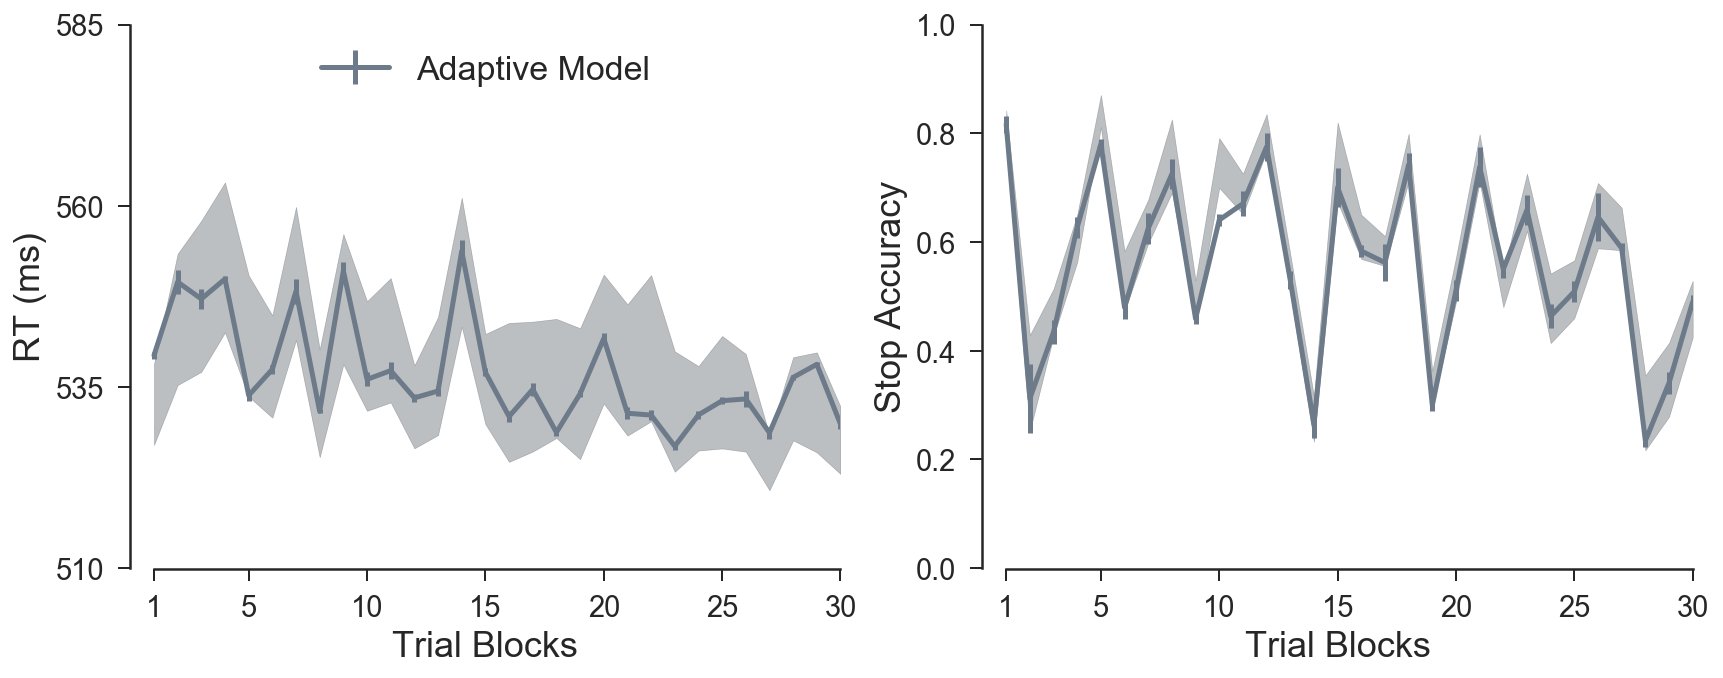

In [16]:
vis.trialwise_model_predictions(apopt, adpm, nsims=5, nblocks=30, c=uc)

## Build aDPM model with all Context data

In [26]:
# instantiate model with learn = True for adaptive DPM
adpmAll = build.Model(data=data, kind='dpm', learn=True)
# set some optimization parameters
adpmAll.set_fitparams(inits=apopt, dt=.005, ntrials=30000)

## Simulate aDPM in Early/Late Contexts with Uniform params

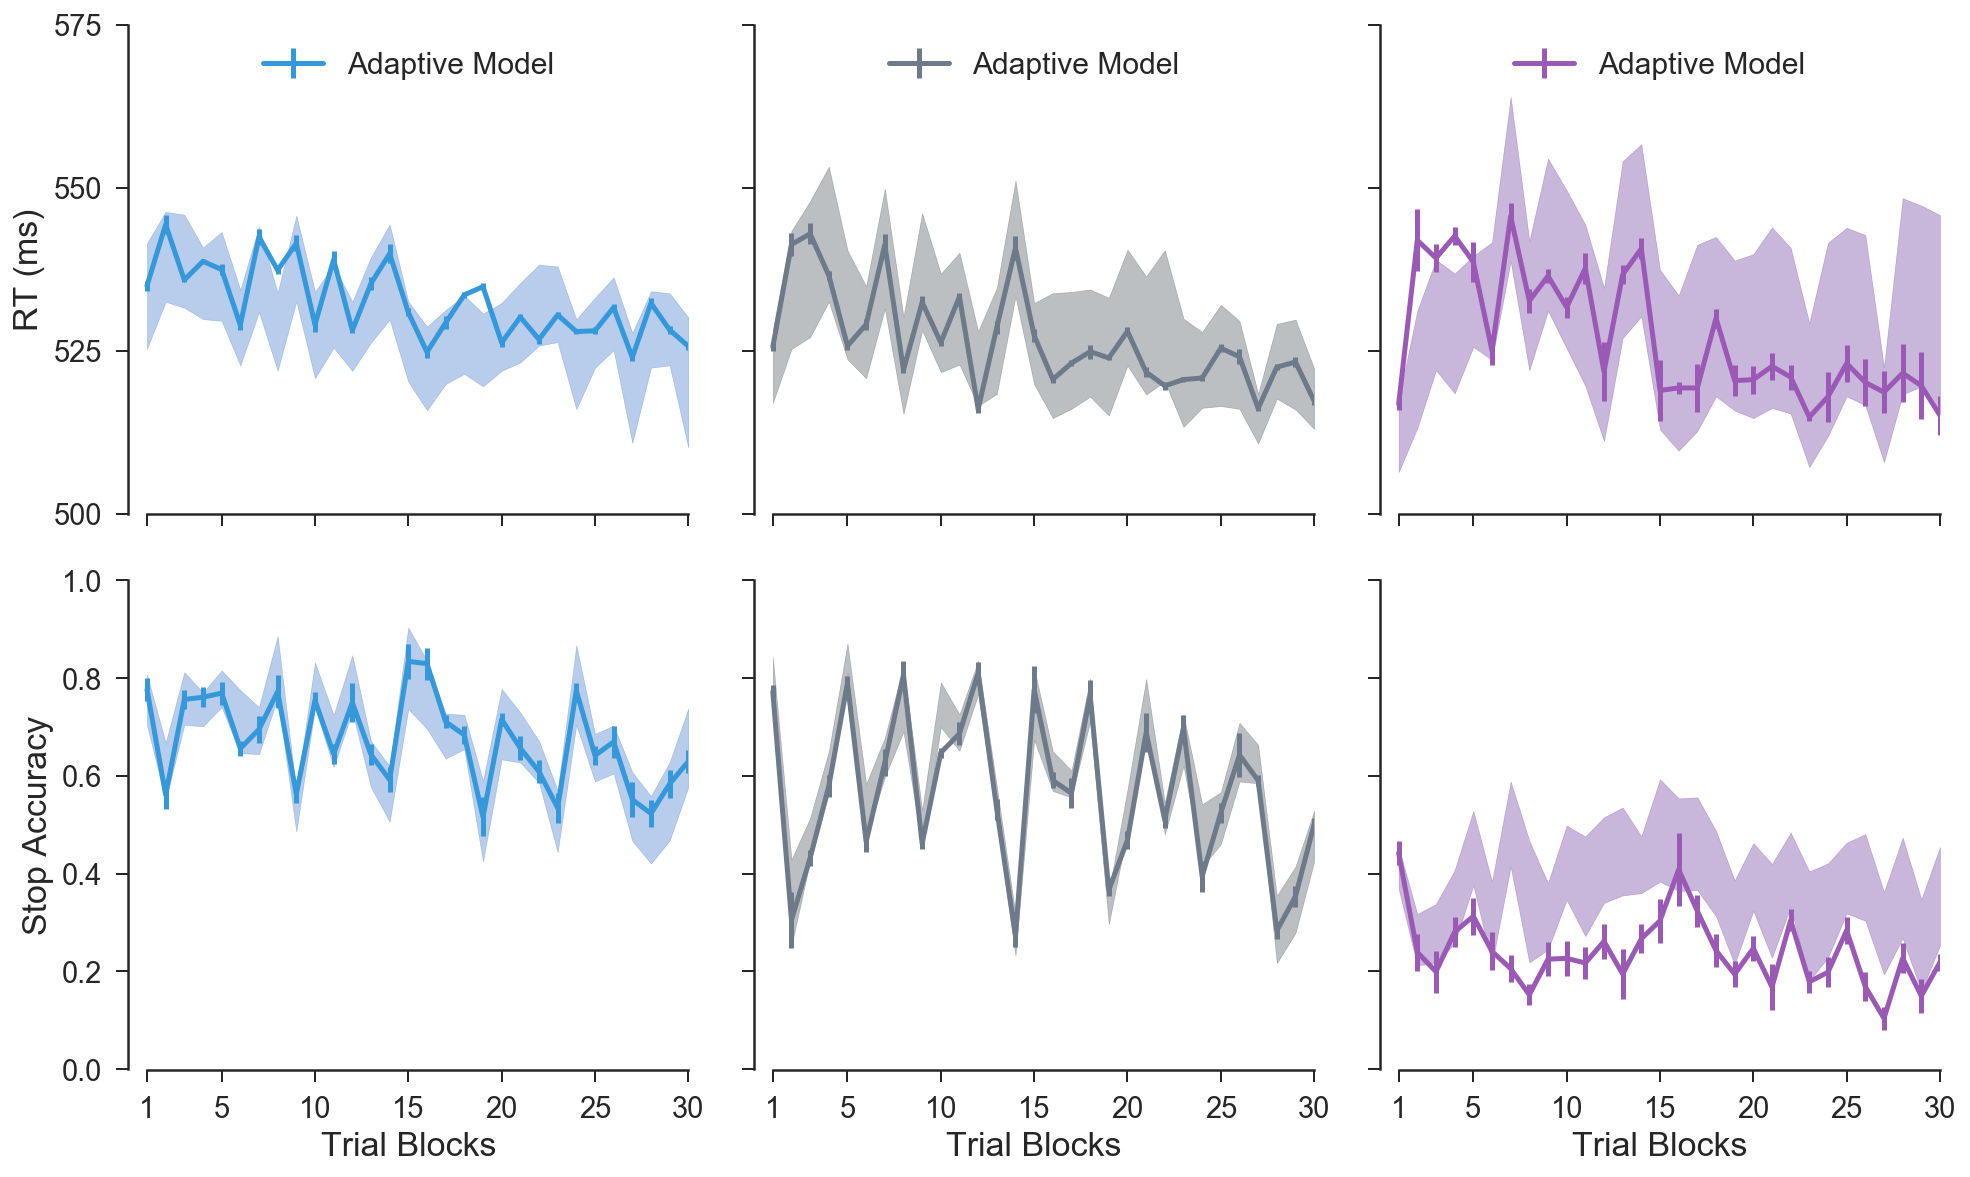

In [37]:
adpmAll.set_fitparams(inits=apopt, dt=.005, ntrials=15000)
vis.trialwise_model_predictions_all(apopt, adpmAll, data=data, nblocks=30)